In [1]:
import os
import zipfile
import shutil

# Preprocessing and Plotting Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

# Tools for training model
import tensorflow as tf
from keras.models import Model
from keras.applications import vgg16
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import Callback, EarlyStopping

#Tools for evaluation of model
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
os.getcwd()

'/kaggle/working'

In [3]:
dir = '../input/a-large-scale-fish-dataset/Fish_Dataset'
data_dir = '../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

In [4]:
print(data_dir)

../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset


In [5]:
os.getcwd()

'/kaggle/working'

In [6]:
label = []
path = []
for dirname, subdirs, filenames in os.walk(dir):
  for filename in filenames:
    if dirname.split()[-1] != 'GT':
        if os.path.splitext(filename)[1] == '.png':
          label.append(os.path.split(dirname)[1])
          path.append(os.path.join(dirname, filename))

image_df = pd.DataFrame(columns = ['Path', 'Label'])
image_df['Path'] = path
image_df['Label'] = label
image_df = image_df.sample(frac = 1, random_state=42).reset_index(drop = True)
image_df.head()

,Path,Label
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Gilt-Head Bream
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Black Sea Sprat
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Trout
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream


In [7]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Path    9000 non-null   object
 1   Label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


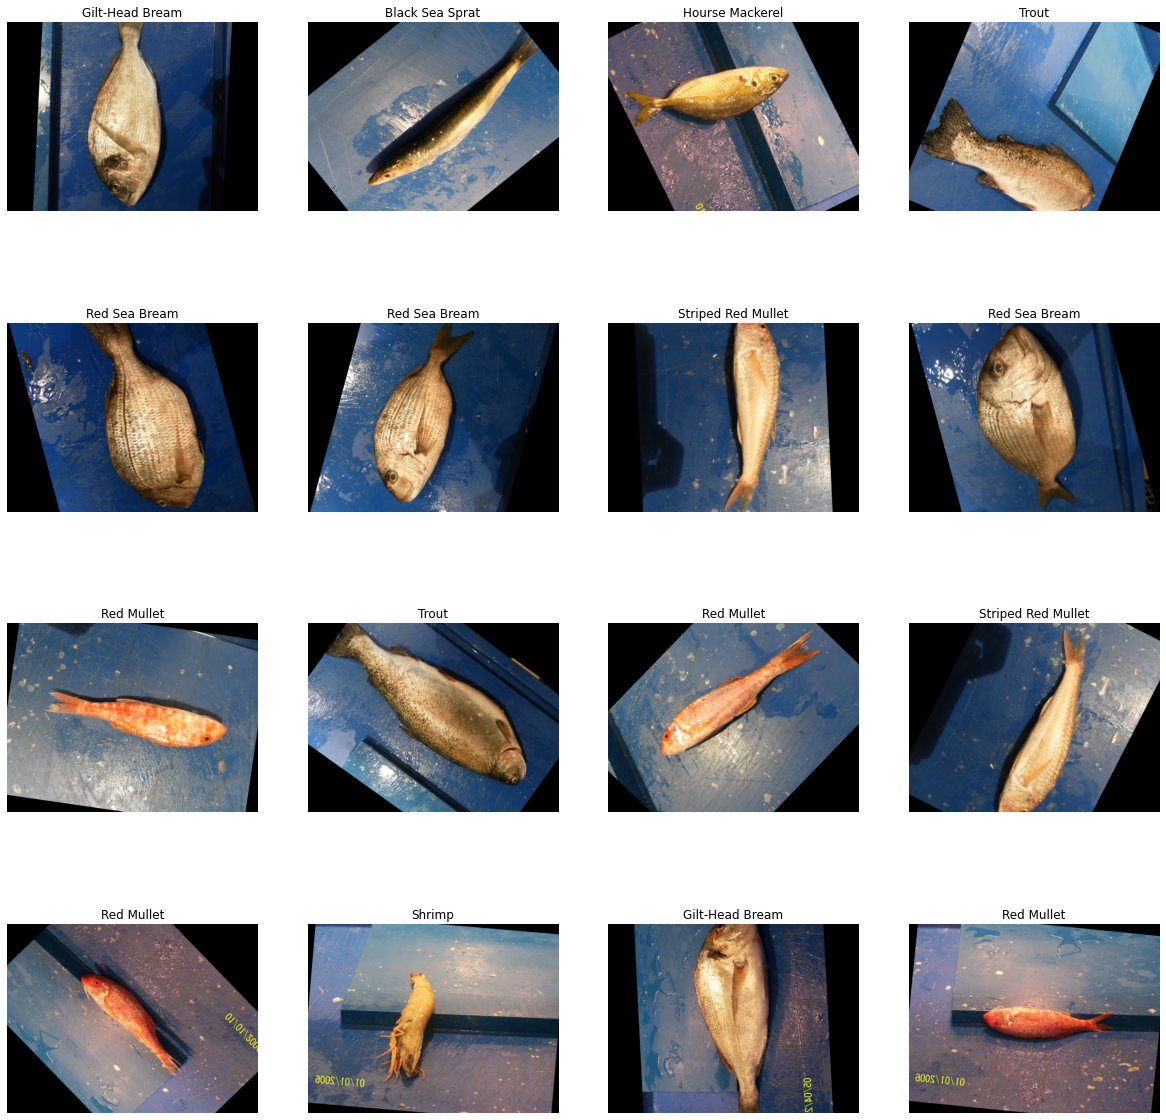

In [8]:
fig, axes = plt.subplots(4, 4, figsize = (20, 20))
axarr = axes.flat

for i, axis in enumerate(axarr):
  axis.imshow(plt.imread(image_df['Path'][i]))
  axis.set_title(image_df['Label'][i])
  axis.axis('off')



plt.subplots_adjust(
    left=0.1,
    bottom = 0.1,
    right=0.9,
    top = 0.9,
    wspace=0.2,
    hspace = 0.2    
)

In [9]:
train_df, valid_df = train_test_split(image_df, train_size = 0.9, shuffle = True, random_state = 42)

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=50,                        # Images get randomly rotate to +/- 50 degrees.
    width_shift_range=0.2,                    # Images get shifted in left/right direction. 
    height_shift_range=0.2,                   # Images get shifted in upward/downward direction.

    # Applies shear to image(seems image was taken from a different angle)
    shear_range=20,

    zoom_range=0.2,                           # Clips a zoomed in image
    horizontal_flip=True,                     # Flips the image horizontally
    vertical_flip=True,                       # Flips the image vertically
    rescale=1./255,                           # Normalize input array to range(0, 1)
    preprocessing_function = preprocess_input # Applies preprocessing to input images similar to as applied in VGG16 model.
)

test_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)

In [11]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Path',
    y_col = 'Label',
    target_size = (224, 224),
    class_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = 25,
    shuffle = True,
    seed = 42
)

valid_generator = test_datagen.flow_from_dataframe(
    dataframe = valid_df,
    x_col = 'Path',
    y_col = 'Label',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 25,
    shuffle = True,
    seed = 42
)

Found 8100 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [12]:
pretrained_model = vgg16.VGG16(
    include_top = False,
    input_shape = (224, 224, 3),
    pooling = 'max'
)
pretrained_model.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [13]:
inputs = pretrained_model.input

x = Dense(128, activation = 'relu')(pretrained_model.output)
x = Dense(128, activation = 'relu')(x)

outputs = Dense(9, activation = 'softmax')(x)


model = Model(inputs = inputs, outputs = outputs)

In [14]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = 'accuracy'
)

callbacks_ = [EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0,
    patience = 1,
    mode = 'auto'
)]

In [15]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 4,
    callbacks = callbacks_
)

Epoch 1/4
324/324 [==============================] - 2238s 7s/step - loss: 1.2557 - accuracy: 0.5582 - val_loss: 0.2264 - val_accuracy: 0.9311
Epoch 2/4
324/324 [==============================] - 2220s 7s/step - loss: 0.3179 - accuracy: 0.8893 - val_loss: 0.1253 - val_accuracy: 0.9633
Epoch 3/4
324/324 [==============================] - 2228s 7s/step - loss: 0.2320 - accuracy: 0.9209 - val_loss: 0.0699 - val_accuracy: 0.9822
Epoch 4/4
324/324 [==============================] - 2205s 7s/step - loss: 0.2011 - accuracy: 0.9314 - val_loss: 0.1029 - val_accuracy: 0.9656


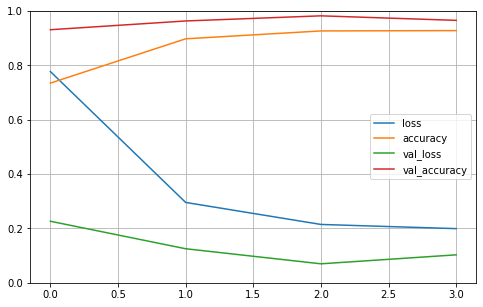

In [16]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [17]:
model.save('./'+'VGG_16 transfer.tf')
del model

In [18]:
# Loading the model and viewing the summary.
model = tf.keras.models.load_model('VGG_16 transfer.tf')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe = valid_df,
    x_col = 'Path',
    y_col = 'Label',
    target_size = (224, 224),
    batch_size = 25,
    shuffle = False,
)

Found 900 validated image filenames belonging to 9 classes.


In [20]:
#Names of different classes of fishes are available in class_indices as dictionary
class_dict = {value : key for key, value in train_generator.class_indices.items()}
print(class_dict.values())

dict_values(['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout'])


In [21]:
pred = model.predict(test_generator)
predicted_classes = [class_dict[i] for i in np.argmax(pred, axis = 1)]
actual_classes = [class_dict[i] for i in np.array(test_generator.classes)]

In [23]:
from sklearn.metrics import accuracy_score
Acc_Score = accuracy_score(actual_classes, predicted_classes)
print("Accuracy Score:", Acc_Score)

Accuracy Score: 0.9655555555555555


In [24]:
confusion_matrix(actual_classes, predicted_classes)

array([[106,   0,   2,   0,   0,   0,   0,   5,   0],
       [  0,  91,   0,   0,   3,   0,   0,   0,   0],
       [  0,   0,  87,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  92,   0,   0,   0,   4,   0],
       [  0,   0,   0,   0, 109,   0,   0,   0,   0],
       [  1,   2,   2,   0,   0,  86,   2,   1,   0],
       [  0,   0,   0,   0,   0,   1, 100,   2,   0],
       [  0,   0,   0,   0,   0,   0,   0, 108,   0],
       [  0,   2,   0,   0,   4,   0,   0,   0,  90]])

In [26]:
print(classification_report(actual_classes, predicted_classes))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.99      0.94      0.96       113
   Gilt-Head Bream       0.96      0.97      0.96        94
   Hourse Mackerel       0.96      1.00      0.98        87
        Red Mullet       1.00      0.96      0.98        96
     Red Sea Bream       0.94      1.00      0.97       109
          Sea Bass       0.99      0.91      0.95        94
            Shrimp       0.98      0.97      0.98       103
Striped Red Mullet       0.90      1.00      0.95       108
             Trout       1.00      0.94      0.97        96

          accuracy                           0.97       900
         macro avg       0.97      0.97      0.97       900
      weighted avg       0.97      0.97      0.97       900

